# TASK 1: $A^*$ 8-PUZZLE with A Star

## I. State space modeling (Requirement 1)

### 1. State ($S$)

* **Definition:** The current configuration of the 3x3 board.
* **Data format:** To ensure immutability and allow it to be used as a key in the hash table (`best_g_cost`), the state $S$ is represented as **Tuple**.
    * *Ex:* `((1, 2, 3), (4, 5, 6), (7, 8, 0))`

### 2. Initial and Goal States

* **Initial state ($S_0$):** The initial board configuration provided.
* **Goal State Set. ($G$):** The set containing the 4 given goal configurations.

### 3. Action set ($A$)

An action is modeled as a **Complex Operator** representing the sequence **Move $\to$ Swap**.

* **Action Format:** `(move_direction, swap_action)`.
    * `move_direction`: is one of `{'L', 'R', 'U', 'D'}`.
    * `swap_action`: s either a pair of coordinates `((r1, c1), (r2, c2))` or `None`.
* **Game rule:** The `get_actions(S)` function enumerates **all** (Move $\to$ Swap) equences applicable to state.

### 4. State Transition Function. (Successor Function)

$$\text{Successor}(S, A) \to S'$$

* **Function:** Given $S$ and $A=(Move, Swap)$, execute sequentially:
    1.  Apply the Move $\to$ **intermediate state** $S_{\text{temp}}$.
    2.  Apply the Swap $\to$ **next state** $S'$.

### 5. Step-cost function 

$$\text{Cost}(S, A, S') = 1$$

* **Cost:** Each complex action (Move $\to$ Swap) is assigned a cost of 1.


## II. A* Algorithm and Heuristic Analysis (Requirement 2)

### 1. Implementing the $A^*$ Algorithm

* **Evaluation Function:** $f(n) = g(n) + h(n)$
    * $g(n)$: The actual accumulated cost from $S_0$ to $n$.
    * $h(n)$: The estimated cost from $n$ to the goal.
* **OOP Structure:** The `Astar` class inherits from `SearchAlgorithm` and is designed to be **generic**, interacting with `EightPuzzleProblem` only through predefined interfaces.

### 2. Analyzing the Two Heuristic Functions

Both heuristic functions use a **Multi-Goal** strategy (taking the `min` distance to the 4 goal configurations).

#### Heuristic 1: Misplaced Tiles ($h_1$)

* **Definition:** Counts the number of tiles (excluding 0) that are currently in the wrong position compared to the goal.
* **Admissibility Analysis ($h_1 \le h^*$):** **Yes.** Since one move has a cost of 1 and can correct up to 3 tiles (1 Move, 2 Swap), $h_1$ remains an optimistic estimate and is always less than or equal to the actual cost $h^*$.
* **Consistency Analysis ($h(S) \le 1 + h(S')$):** **Yes (almost always).** It’s very unlikely for $h_1$ to decrease by more than 1 in a single step (cost = 1), so consistency is preserved.

#### Heuristic 2: Euclidean Distance ($h_2$)

* **Definition:**  Calculates the total straight-line (Euclidean) distance for all tiles from their current positions to their goal positions.

* **Admissibility Analysis ($h_2 \le h^*$):**  **Not guaranteed.** In this 8-puzzle variant, an action (swap) may move two tiles simultaneously or swap distant corners. This means the true cost to fix multiple tiles could be **less than** their Euclidean sum. Hence, Euclidean distance can **overestimate** the real cost, violating admissibility.

* **Consistency Analysis ($h(S) \le 1 + h(S')$):** **Not always.** A single swap can drastically reduce the total Euclidean distance, meaning the heuristic difference can exceed the step cost (1). Therefore, $h_2$ does not always satisfy the consistency condition.


## III. Implementation

#### CLASS DIAGRAMS
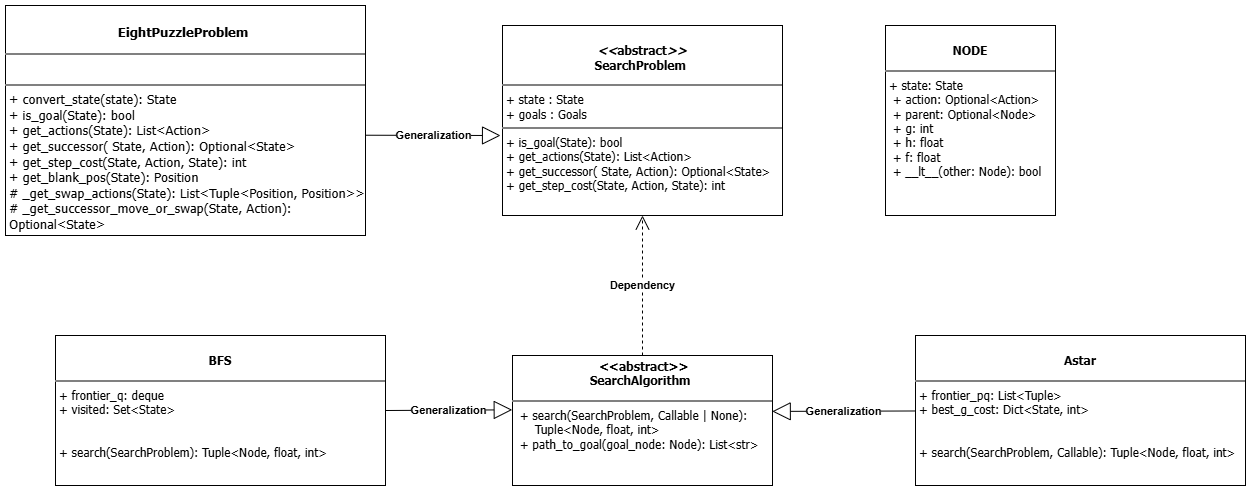
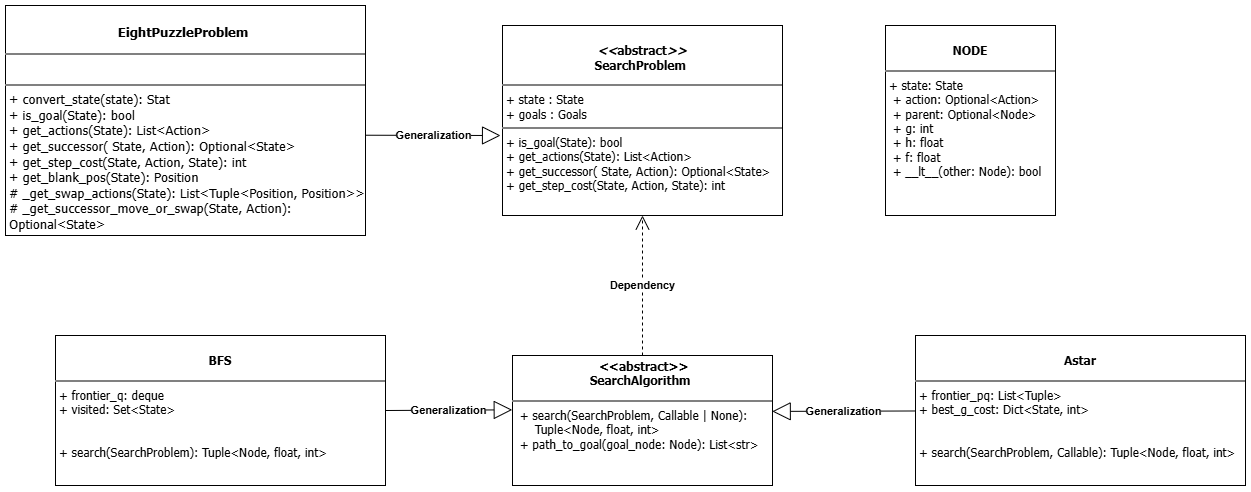

### Libraries

In [1]:
import math
from graphviz import Digraph
import random
import time
import heapq
from collections import deque
from typing import Tuple, List, Set, Optional, Callable, Any, Literal

In [2]:
#* Định nghĩa các kiểu dữ liệu tùy chỉnh
State = Tuple[Tuple[int, ...], ...]
Goals = Set[State]
Position = Tuple[int, int]
MoveDirection = Literal['L', 'R', 'U', 'D']
SwapAction = Optional[Tuple[Position, Position]]
Action = Tuple[MoveDirection, SwapAction]
HeuristicFunc = Callable[[State, Goals], float] # Kiểu cho hàm Heuristic

### SearchProblem: Problem Abstraction

In [3]:
class SearchProblem:
  def __init__(self, initial:List[List[int]] , goals: List[List[List[int]]] | Goals | None = None, *args: Any):
    self.initial: State = initial if isinstance(initial[0], tuple) else tuple(tuple(row) for row in initial)
    self.goals: Goals | None = goals if isinstance(goals, set) else set(tuple(tuple(row) for row in goal) for goal in goals) if goals else None
    
  def is_goal(self, state: State) -> bool: raise NotImplementedError
  def get_actions(self, state: State) -> List[Action]: raise NotImplementedError
  def get_successor(self, state: State, action: Action) -> Optional[State]: raise NotImplementedError
  def get_step_cost(self, state: State, action: Action, next_state: State) -> int: return 1

#### Implementing the 8-Puzzle Problem: EightPuzzleProblem (Inherits from SearchProblem)

In [4]:
class EightPuzzleProblem(SearchProblem):
  def __init__(self,initial: List[List[int]] | State,goals: List[List[List[int]]] | Goals):
    super().__init__(initial, goals)
    self.initial: State = self._convert_state(initial)
    self.goal: Goals = set(self._convert_state(goal) for goal in goals)
    
  def _convert_state(self, state: List[List[int]] | State) -> State: 
    if isinstance(state[0],list): return tuple(tuple(row) for row in state)
    return state
  
  #! Hàm kiểm tra có phải goal không
  def is_goal(self,state: State) -> bool:
    return state in self.goal
  
  #! Lấy các action (L,swap)
  def get_actions(self, state: State) -> List[Action]:
    actions_move = []
    actions = ['L','R','U','D']
    for action in actions:
      successor_state = self._get_successor_move_or_swap(state,action) #* Lấy successor
      if successor_state is None: continue
      swap_actions = self._get_swap_actions(successor_state) #* Lấy các hành động có thể swap dựa trên hành động mới xảy ra
      if swap_actions: 
        for swap_action in swap_actions:
          actions_move.append((action,swap_action))
      else: actions_move.append((action,None))
    return actions_move 
  
  #! Lấy láng giềng
  def get_successor(self,state: State,actions_move: Action) -> Optional[State]:
    #* action_move có dạng ví dụ: ('l',((0,1),(0,2))) hoặc ('L',None)
    action_normal, action_swap = actions_move
    successor_node = self._get_successor_move_or_swap(state,action_normal)
    if successor_node is None: return None
    if action_swap is None: return successor_node
    return self._get_successor_move_or_swap(successor_node,action_swap)
    
    
  #* Lấy các vị trí tiếp theo (Có thể hoán đổi) => actions
  def _get_swap_actions(self, state: State) -> List[Tuple[Position, Position]]:
    pairs_swap = [] #* Định dạng khi lưu (pos_a, pos_b)
    for i in range(3): # i là hàng
      for j in range(3): # j là cột
        #* Kiểm tra Ngang liền kề
        if j < 2: 
          if state[i][j] + state[i][j+1] == 9:
            pairs_swap.append(((i,j), (i,j+1)))
        #* Kiểm tra Dọc liền kề
        if i < 2: 
          if state[i][j] + state[i+1][j] == 9:
            pairs_swap.append(((i,j), (i+1,j)))

    #* kiểm tra 2 đường chéo
    if state[0][0]!=0 and state[2][2]!=0:
      pairs_swap.append(((0,0),(2,2)))
    if state[0][2]!=0 and state[2][0]!=0:
      pairs_swap.append(((0,2),(2,0)))
    return pairs_swap 
  
  
  #* Lấy các successor dựa trên các action ( 1 là LRUD , 2 là swap)
  def _get_successor_move_or_swap(self, state: State, action: MoveDirection | Tuple[Position, Position]) -> Optional[State]:
    actions = ['L','R','U','D']
    state_list = [list(row) for row in state] #* Đổi thành list để có thể gán value
    moves = {
        'L': (0, 1),
        'R': (0, -1),
        'U': (1, 0),
        'D': (-1, 0)
		}
    #* 1. KIỂM TRA ACTION DI CHUYỂN Ô TRỐNG ('L', 'R', 'D', 'U')
    if isinstance(action, str) and action in actions:
        #* Action hợp lệ (ví dụ: 'L')
        pi, pj = self.get_blank_pos(state_list)
        di, dj = moves[action] #* Lấy hướng di chuyển (ví dụ: (0, 1) cho 'L')
        ni, nj = pi + di, pj + dj 
        if 0 <= ni < 3 and 0 <= nj < 3:
            #* Di chuyển ô số vào vị trí ô trống
            state_list[pi][pj], state_list[ni][nj] = state_list[ni][nj], state_list[pi][pj]
            return tuple(tuple(row) for row in state_list)
        return None  
      
    #* 2. KIỂM TRA ACTION HOÁN ĐỔI (SWAP)
    #* Action phải là tuple của hai tuple: ((r1, c1), (r2, c2))
    elif isinstance(action, tuple) and len(action) == 2 :
      pos_a, pos_b = action
      i_a, y_a = pos_a
      i_b, y_b = pos_b
      
      #* Đảm bảo các chỉ số nằm trong biên (3x3)
      if (0 <= i_a < 3 and 0 <= y_a < 3) and (0 <= i_b < 3 and 0 <= y_b < 3):
        #* Thực hiện hoán đổi
        state_list[i_a][y_a], state_list[i_b][y_b] = state_list[i_b][y_b], state_list[i_a][y_a]
        return tuple(tuple(row) for row in state_list)
      
      return None #*Hoán đổi không hợp lệ/ngoài biên
    return None
  
  #! Lấy vị trí ô trống
  def get_blank_pos(self, state: State) -> Position:
    return next((i,j) for i, row in enumerate(state) for j, val in enumerate(row) if val==0 )
  
  #! Tính chi phí bước đi
  def get_step_cost(self, state: State, action: Action, next_state: State) -> int:
    return 1 

### Implementing the Node

In [5]:
class Node:
  def __init__(self, state: State, action: Optional[Action] = None, parent: Optional['Node'] = None, g: int = 0, h: float = 0.0 ):
    self.state: State = state
    self.action: Optional[Action] = action
    self.parent: Optional['Node'] = parent
    self.g: int = g
    self.h: float = h
    
  @property
  def f(self):
    return self.g + self.h  
  def __hash__(self):
    return hash(self.state)
  def __eq__(self, other):
    if isinstance(other, Node):
      return self.state == other.state
    return False
  def __lt__(self, other: 'Node') -> bool:
    return self.f < other.f

### Implementing the Heuristic Function

In [6]:
def h_misplaced_multigoal(state: State, goals: Goals) -> float:
  def calculate_single_h(state, goal):
    return sum(
      1
      for i in range(3) for j in range(3)
      if state[i][j] != 0 and state[i][j] != goal[i][j]
		)
  return min(calculate_single_h(state, g) for g in goals)

def h_euclidean_multigoal(state: State, goals: Goals) -> float:
    def get_coords(current_state_tuple, tile):
        for r in range(3):
            for c in range(3):
                if current_state_tuple[r][c] == tile:
                    return r, c
        return -1, -1
    min_h = float('inf')
    current_state_tuple = tuple(state)
    for goal_state in goals:
        total_h3_cost = 0.0
        for tile in range(1, 9):
            r_current, c_current = get_coords(current_state_tuple, tile)
            r_goal, c_goal = get_coords(goal_state, tile)
            d_euclidean = math.sqrt(
                (r_current - r_goal)**2 + (c_current - c_goal)**2
            )
            total_h3_cost += d_euclidean
        min_h = min(min_h, total_h3_cost)
    return min_h

### SearchAlgorithm: Search Algorithm Abstraction

In [7]:
class SearchAlgorithm:
  def search(self, problem: SearchProblem, heuristic:HeuristicFunc | None=None, *args: any): 
    raise NotImplementedError
  
  def path_to_goal(self,goal_node: Node) -> List[str]:
    path = []
    cur = goal_node
    while cur.parent is not None:
      path.append(cur.action[0])
      cur=cur.parent
    return path[::-1]

#### Implementing $A^*$ by Inheriting from SearchAlgorithm

In [8]:
class Astar(SearchAlgorithm):
  def search(self, problem: SearchProblem, heuristic: HeuristicFunc) -> Tuple[Optional['Node'], float, int]:
    self.start_time = time.time()
    self.frontier_pq = [] 
    self.expanded_states = set()
    self.best_g_cost= {}
    expanded_count  = 0
    #* Tạo giá trị ban đầu
    initial = problem.initial
    h_initial = heuristic(initial, problem.goals)
    initial_node = Node(state=initial, g=0, h=h_initial)
    self._push_to_frontier(initial_node)
    
    #* Lặp đến khi frontier rỗng
    while self.frontier_pq:
      f,g,node_hash,node = heapq.heappop(self.frontier_pq)
      #* Nếu g-cost của node này > g-cost tốt nhất đã lưu, bỏ qua (đã xử lý)
      if node.g > self.best_g_cost.get(node.state, float('inf')):
        continue
      
      
      expanded_count +=1
      
      #* Nếu thấy goal thì trả về  
      if problem.is_goal(node.state):
        return node, time.time() - self.start_time,expanded_count
      
      for action_move in problem.get_actions(node.state):
        next_state = problem.get_successor(node.state,action_move) #* Lấy successor
        if next_state is not None:
          step_cost = problem.get_step_cost(node.state, action_move, next_state)
          new_g_cost = node.g + step_cost
          h_cost = heuristic(next_state, problem.goals)
            
          #* Nếu chi phí mới thấp hơn chi phí cũ thì lưu 
          cur_best_g_cost = self.best_g_cost.get(next_state, float('inf'))
          if new_g_cost < cur_best_g_cost:
            self.best_g_cost[next_state] = new_g_cost
            new_node = Node(state=next_state,action=action_move,parent=node,g=new_g_cost,h=h_cost)
            self._push_to_frontier(new_node)

    return None,time.time() - self.start_time,expanded_count
  
  #* push vào frontier
  def _push_to_frontier(self, node: Node) -> None:
    heapq.heappush(self.frontier_pq, (node.f, node.g, hash(node.state), node))


#### Implementing BFS by Inheriting from SearchAlgorithm

In [9]:
class BFS(SearchAlgorithm):
  def search(self, problem: SearchProblem, heuristic: None=None) -> Tuple[Optional['Node'], float, int]:
    self.start_time = time.time()
    self.frontier_q = deque() 
    self.visited= set()
    expanded_count  = 0
    #* Tạo giá trị ban đầu
    initial = problem.initial
    initial_node = Node(state=initial)
    self.frontier_q.append(initial_node)
    
    self.visited.add(initial_node.state)
    
    #* Lặp đến khi frontier rỗng   
    while self.frontier_q:
      node = self.frontier_q.popleft()
      if problem.is_goal(node.state):
        return node, time.time() - self.start_time,expanded_count
      expanded_count+=1
      for action in problem.get_actions(node.state):
        next_state = problem.get_successor(node.state,action) #* Lấy successor
        if next_state is not None:   
          if next_state not in self.visited:
            step_cost = problem.get_step_cost(node.state, action, next_state)
            new_g_cost = node.g + step_cost
            successor = Node(state=next_state,action=action,parent=node,g=new_g_cost)
            self.visited.add(node.state)
            self.frontier_q.append(successor)
          
    return None,time.time() - self.start_time,expanded_count

### Implement a visualization function for $A^*$ with n search nodes

In [10]:

#! Hàm vẽ
def draw_astar(problem,  heuristic, max_node ):
  dot = Digraph(comment='A* Search Expansion', graph_attr={'rankdir': 'TB'})
  frontier_pq = [] 
  best_g_cost= {}
    
  #* Khởi tạo giá trị ban đầu
  initial = problem.initial
  h_initial = heuristic(initial, problem.goal)
  initial_node = Node(state=initial, g=0, h=h_initial)
  count = 0
  is_goal = False
  heapq.heappush(frontier_pq, (initial_node.f, initial_node.g, hash(initial_node.state), initial_node))

  print("-" * 70)
  print(f"Drawing A* EXPANSION")
  print("-" * 70)
  
    #* Lặp đến khi frontier rỗng
  while frontier_pq:
    f,g,node_hash,node = heapq.heappop(frontier_pq)
      
      #* Nếu g-cost của node này > g-cost tốt nhất đã lưu, bỏ qua (đã xử lý)
    if node.g > best_g_cost.get(node.state, float('inf')):
        continue
    is_current_goal = problem.is_goal(node.state)
    
    #* Vẽ node : Chỉ vẽ đầy đủ thuộc tính khi mở rộng
    draw(node , dot, is_goal=is_current_goal)
    count += 1
    if count >= max_node:
      print(f"[FINISH] Stop after expeanded {count} nodes.")
      return dot
    if problem.is_goal(node.state):
      is_goal = True
      break
      
    #* mở rộng các successor với action thường L R D U
    for action_move in problem.get_actions(node.state):
        next_state = problem.get_successor(node.state,action_move) #* Lấy successor
        if next_state is not None:
          step_cost = problem.get_step_cost(node.state, action_move, next_state)
          new_g_cost = node.g + step_cost
          h_cost = heuristic(next_state, problem.goal)
            
          #* Nếu chi phí mới thấp hơn chi phí cũ thì lưu 
          cur_best_g_cost = best_g_cost.get(next_state, float('inf'))
          if new_g_cost < cur_best_g_cost:
            best_g_cost[next_state] = new_g_cost
            new_node = Node(state=next_state,action=action_move,parent=node,g=new_g_cost,h=h_cost)
            heapq.heappush(frontier_pq, (new_node.f, new_node.g, hash(new_node.state), new_node))

  if is_goal:
    print(f"[SUCCESS] Goal found after expanded {count} nodes.")
    return dot
  else:
    print(f"[KẾT THÚC] Stop. Expanded {count} nodes.")
    return dot 
  
  
#* Đổi định dạng để vẽ
def convert_node(node):
  string=""
  for row in node.state:
    for s in row:
      string +=str(s) if s !=0 else "_"
    string +="\n"
  return string.rstrip("\n")

def get_action_display(node):
  if node.action is None:
    return ""
  move, pos_swap = node.action
  swap_str = ""
  if pos_swap is not None:
    pos_a, pos_b = pos_swap
    val_a = node.state[pos_a[0]][pos_a[1]] 
    val_b = node.state[pos_b[0]][pos_b[1]]
    swap_str = f"↓\n({val_a})→({val_b})" 
    if swap_str:
      return f"[{move}]\n{swap_str}"
    else:
      return f"[{move}]"
  
def draw(node, dot,is_goal=False):
  if is_goal:
      color = "#02ff02" 
  elif node.parent is None:
      color = "#4eacff"
  else:
      color = 'white'
  dot.node(str(hash(node.state)), convert_node(node),shape="square",style='filled',fillcolor=color)
  if node.parent is not None:
    dot.edge(str(hash(node.parent.state)), str(hash(node.state)), get_action_display(node))

### Heuristic Evaluation Function Implementation

In [11]:
def evaluate_heuristics(problem_class, initial_states, goals, heuristic_list):
  results = {}
  #* 1. Khởi tạo Astar
  astar = Astar()
  
  #* 2. Lặp qua các hàm Heuristic 
  for name, heuristic_func in heuristic_list:
    total_time = 0
    total_expanded_nodes = 0
    successful_runs = 0

    for initial_state in initial_states:
      problem = problem_class(initial=initial_state, goals=goals)
      node_goal, time_taken, expanded_nodes = astar.search(problem=problem, heuristic=heuristic_func)

      if node_goal is not None:
        total_time += time_taken
        total_expanded_nodes += expanded_nodes
        successful_runs += 1

    #* 3. Tổng hợp kết quả
    if successful_runs > 0:
      results[name] = {
        "avg_time": total_time / successful_runs,
        "avg_expanded_nodes": total_expanded_nodes / successful_runs,
        "success_rate": successful_runs / len(initial_states)
      }
    else:
      results[name] = {
        "avg_time": float('inf'),
        "avg_expanded_nodes": float('inf'),
        "success_rate": 0
      }
  return results

### Initialization

In [12]:

#* Hàm Random initail vì tính khả thi nên giả định lấy trạng thái ban đầu ngược từ goals
def generate_random_initial_state(steps: int = 100) -> List[List[int]]:

    problem_instance = EightPuzzleProblem(goals[0], goals)
    tiles = [0, 1, 2, 3, 4, 5, 6, 7, 8]
    random.shuffle(tiles)
    solvable_goals = [tuple(tuple(row) for row in goal) for goal in goals]
    current_state = random.choice(solvable_goals)
    
    for _ in range(steps):
        actions = problem_instance.get_actions(current_state)
        if not actions:
            continue
        action = random.choice(actions)
        next_state = problem_instance.get_successor(current_state, action)
        if next_state is not None:
            current_state = next_state
    initial_state_list = [list(row) for row in current_state]
    return initial_state_list
  
#* Khởi tạp Goal
goals= [[[1 ,2 ,3],
        [4 ,5 ,6],
        [7 ,8 ,0]],[[8 ,7 ,6],
                    [5 ,4 ,3],
                    [2 ,1 ,0]],[[1 ,2 ,0],
                                [3 ,4 ,5],
                                [6 ,7 ,8]],[[8 ,7 ,0],
                                            [6 ,5 ,4],
                                            [3 ,2 ,1]],]
#* Khởi tạo A*
astar = Astar()

# #* Khởi tạo Initial 
random_state = generate_random_initial_state(10) 
#* Khơi tạo Problem
eight_puzzle_problem = EightPuzzleProblem(initial=random_state ,goals=goals)

### Run Heuristic Evaluation

In [13]:

#* 1. Tạo danh sách các trạng thái khởi đầu để kiểm tra
test_initial_states = [generate_random_initial_state() for i in range(0,10)]

#* 2. Định nghĩa danh sách Heuristic
heuristics_to_test = [
    ("Misplaced Tiles", h_misplaced_multigoal),
    ("Euclid Distance", h_euclidean_multigoal),
]

#* 3. Chạy đánh giá
evaluation_results = evaluate_heuristics(
    problem_class=EightPuzzleProblem,
    initial_states=test_initial_states,
    goals=goals,
    heuristic_list=heuristics_to_test
)

#* 4. In kết quả 
print("\n" + "="*60)
print("PERFORMANCE EVALUATION OF HEURISTIC FUNCTIONS")
print("="*60)
for name, data in evaluation_results.items():
  print(f"Heuristic: {name}")
  print(f"  - Average time: {data['avg_time']:.4f}s")
  print(f"  - Average expanded nodes: {data['avg_expanded_nodes']:.2f} nodes")
  print(f"  - Success Rate: {data['success_rate'] * 100:.1f}%")
  print("-" * 30)


PERFORMANCE EVALUATION OF HEURISTIC FUNCTIONS
Heuristic: Misplaced Tiles
  - Average time: 3.2340s
  - Average expanded nodes: 18335.90 nodes
  - Success Rate: 100.0%
------------------------------
Heuristic: Euclid Distance
  - Average time: 1.9617s
  - Average expanded nodes: 3852.30 nodes
  - Success Rate: 100.0%
------------------------------


### Run the Problem

In [14]:
print("Initial:",random_state)

#* Thực thi A*
result_astar , time_astar , expanded_astar = astar.search(problem=eight_puzzle_problem,heuristic=h_euclidean_multigoal)

if result_astar:
    path_astar = astar.path_to_goal(result_astar)
    print(f"A* execution result => Goal found: \n{result_astar.state}")
    print(f"Path to Goals: {path_astar}")
    # Chi phí thực tế là g-cost, f-cost (g+h) chỉ dùng cho tìm kiếm
    print(f"- Cost:{result_astar.g}") 
else: 
    path_astar = []
    print("A* execution result => Goal not found")

print(f"- Expanded Nodes:{expanded_astar}")
print(f"- A* execution time: {time_astar:.4f} s")
print("-" * 70)

#* Thực thi BFS
bfs = BFS()
result_bfs , time_bfs, expanded_bfs = bfs.search(problem=eight_puzzle_problem)

if result_bfs:
    path_bfs = bfs.path_to_goal(result_bfs)
    print(f"BFS Execution Result => Goal Found: \n{result_bfs.state}")
    print(f"Path to Goals: {path_bfs}")
    print(f"- Cost:{result_bfs.g}")
else:
    path_bfs = []
    print("BFS execution result => Goal not found")
    
print(f"- Expanded Nodes:{expanded_bfs}")
print(f"- BFS execution time: {time_bfs:.4f} s")
  
print("-"*70)

dot = draw_astar(problem=eight_puzzle_problem,heuristic=h_euclidean_multigoal,max_node=20) 
dot.render(filename='astar_expansion_graph', format='png',view=True,cleanup=True )

Initial: [[8, 3, 4], [6, 0, 5], [2, 7, 1]]
A* execution result => Goal found: 
((1, 2, 0), (3, 4, 5), (6, 7, 8))
Path to Goals: ['L', 'D', 'R', 'L', 'U', 'D']
- Cost:6
- Expanded Nodes:26
- A* execution time: 0.0145 s
----------------------------------------------------------------------
BFS Execution Result => Goal Found: 
((8, 7, 0), (6, 5, 4), (3, 2, 1))
Path to Goals: ['L', 'D', 'R', 'L']
- Cost:4
- Expanded Nodes:1106
- BFS execution time: 0.1797 s
----------------------------------------------------------------------
----------------------------------------------------------------------
Drawing A* EXPANSION
----------------------------------------------------------------------
[FINISH] Stop after expeanded 20 nodes.


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH